In [1]:
import yfinance as yf
import bs4 as bs
import pickle
import requests
import pandas as pd
import json
from dateutil import parser
from datetime import datetime
import os
import time
from pandas.io.json import json_normalize
from alpha_vantage.timeseries import TimeSeries
from alpha_vantage.fundamentaldata import FundamentalData
import wrds
from datetime import datetime as dt
import numpy as np
import glob, os
import csv
from matplotlib import pyplot as plt

import yakPak as yP

In [2]:
pd.set_option("display.precision", 8)
%load_ext autoreload
%autoreload 2

In [3]:
# Define start and end of download
# allows for rolling windows
start_download = '2006-04-02'#pd.to_datetime('2009-04-02' , format = '%Y-%m-%d')
end_download = '2020-06-15'#pd.to_datetime('2020-06-15', format = '%Y-%m-%d')

In [4]:
start_date = '2009-06-30'#pd.to_datetime('2009-06-02', format = '%Y-%m-%d') # Define start and end dates
end_date = '2020-02-03'#pd.to_datetime('2020-04-15', format = '%Y-%m-%d')

In [5]:
tickers_ciks= yP.save_SP500_tickers()

In [6]:
tickers = tickers_ciks['ticker'] 
tickers = [item.replace('-','.') for item in tickers]
tickers = [item.replace('.B','-A') for item in tickers]
ciks = tickers_ciks['cik']

In [7]:
changes = pd.read_excel('sp500change.xlsx')
changes['Ticker'] = changes['Ticker'].astype(str)
changes['Ticker'] = [item.replace('-','.') for item in changes['Ticker']]
changes['Ticker'] = [item.replace('.B','-A') for item in changes['Ticker']]
tickers = [x for x in tickers if x not in list(changes['Ticker'])]

In [8]:
data_yf = yf.download(tickers, start=start_download, end=end_download)

[*********************100%***********************]  232 of 232 completed

6 Failed downloads:
- XLNX: No data found, symbol may be delisted
- MYL: No data found, symbol may be delisted
- TIF: No data found, symbol may be delisted
- CTL: No data found, symbol may be delisted
- ETFC: No data found, symbol may be delisted
- BLL: No data found, symbol may be delisted


In [9]:
ac = data_yf['Adj Close']
ac.index = pd.to_datetime(ac.index, format = '%Y-%m-%d')




#oco = (data_yf['Close'] - data_yf['Open'])/data_yf['Open']

In [10]:
ac.index.dtype

dtype('<M8[ns]')

In [11]:
ac = ac.dropna(axis=0, how='all')
ac = ac.dropna(axis=1)

## Rolling Window Calcs

In [12]:
ac = ac.resample('MS').ffill().dropna()

In [13]:
ac_rolling = ac.rolling(12)

In [14]:
ac_mean = ac_rolling.mean()
ac_std = ac_rolling.std()

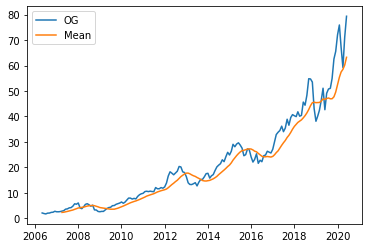

In [15]:
plt.plot(ac['AAPL'], label = 'OG')
plt.plot(ac_mean['AAPL'], label = 'Mean')
plt.legend();

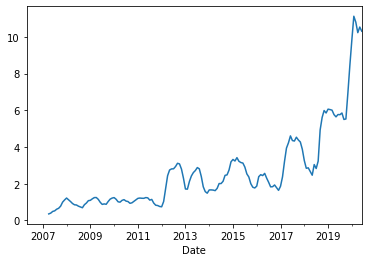

In [16]:
ac_std['AAPL'].plot();

## Augmented Dickey Fuller Test 

In [17]:
# determines if time series is stationary or non-stationary
from statsmodels.tsa.stattools import adfuller

In [18]:
adf_results = adfuller(ac['AAPL'])
print('ADF Stats: ', adf_results[0])
print('p-value: ', adf_results[1])

critical_values = adf_results[4]
for key, value in critical_values.items():
    print('Critical Value (%s): %.3f' % (key, value))
    

ADF Stats:  2.882268257666298
p-value:  1.0
Critical Value (1%): -3.473
Critical Value (5%): -2.880
Critical Value (10%): -2.577


## Detrending

In [19]:
#ac = data_yf['Adj Close']

In [20]:
ac_log = np.log(ac)

In [21]:
ac_log_ma = ac_log.rolling(2).mean()

In [22]:
ac_detrend = ac_log - ac_log_ma
ac_detrend.dropna(inplace = True)

In [23]:
#mean and std of detrended data
ac_detrend_rolling = ac_detrend.rolling(12)
ac_detrend_ma = ac_detrend_rolling.mean()
ac_detrend_std = ac_detrend_rolling.std()

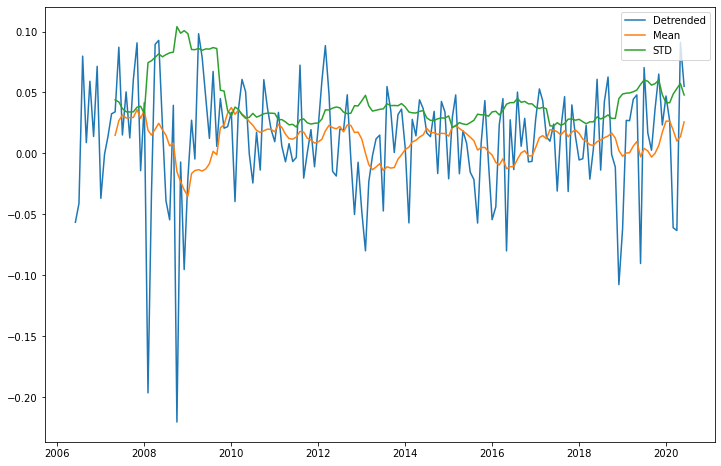

In [24]:
plt.figure(figsize=(12,8))
plt.plot(ac_detrend['AAPL'], label = 'Detrended')
plt.plot(ac_detrend_ma['AAPL'], label = 'Mean')
plt.plot(ac_detrend_std['AAPL'], label = 'STD')
plt.legend(loc = 'upper right');

In [25]:
adf_results = adfuller(ac_detrend['AAPL'])
print('ADF Stats: ', adf_results[0])
print('p-value: ', adf_results[1])

critical_values = adf_results[4]
for key, value in critical_values.items():
    print('Critical Value (%s): %.3f' % (key, value))

ADF Stats:  -11.68291433244685
p-value:  1.7241670838770567e-21
Critical Value (1%): -3.470
Critical Value (5%): -2.879
Critical Value (10%): -2.576


In [26]:
ac_detrend = ac_detrend[start_date:end_date]

In [27]:
#export detrended adjClose
ac_detrend.T.to_csv('Export/ac_detrend.csv') 

## Differencing

In [28]:
ac_log_diff = ac_log.diff(periods=3).dropna()

In [29]:
ac_diff_rolling = ac_log_diff.rolling(12)
ac_diff_ma = ac_diff_rolling.mean()
ac_diff_std = ac_diff_rolling.std()

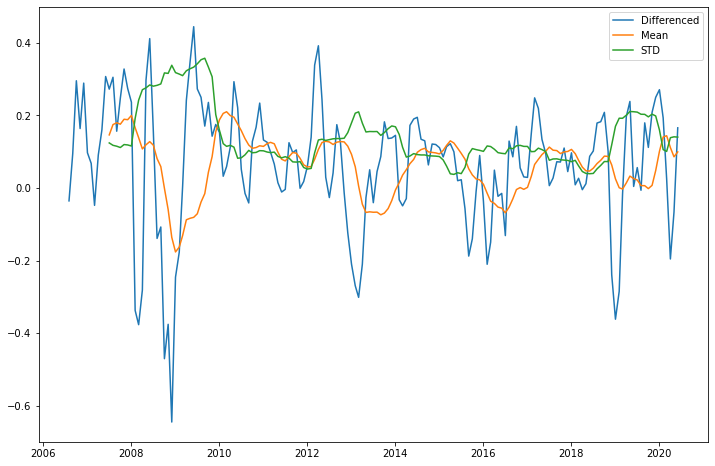

In [30]:
plt.figure(figsize=(12,8))
plt.plot(ac_log_diff['AAPL'], label = 'Differenced')
plt.plot(ac_diff_ma['AAPL'], label = 'Mean')
plt.plot(ac_diff_std['AAPL'], label = 'STD')
plt.legend(loc = 'upper right');

In [31]:
ac_log_diff = ac_log_diff[start_date:end_date]

In [32]:
#export detrended adjClose
ac_log_diff.T.to_csv('Export/ac_diff.csv')

In [33]:
ac_log_diff

,A,AAPL,ABC,ABT,ADBE,ADI,ADM,ADP,ADSK,AEE,...,WHR,WM,WMB,WMT,WY,XEL,XOM,XRX,YUM,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2009-07-01,0.25367261,0.27315550,0.11127758,0.00784111,0.26627984,0.27730989,-0.02299299,0.01575084,0.08671906,0.09688269,...,0.38385740,0.10147008,0.29462233,-0.08263243,0.09341335,0.03506707,0.02497929,0.33692583,0.21944310,0.09130335
2009-08-01,0.21062546,0.25006469,0.14098454,0.08911221,0.16604509,0.26629640,0.17175005,0.05620943,0.10530959,0.07607899,...,0.22885449,0.08190770,0.15062258,0.00197496,0.00888346,0.09445901,0.04034620,0.24687273,0.07413047,0.23938706
2009-09-01,0.31420746,0.17077307,0.12169959,0.01195544,0.05757461,0.11062834,-0.00757253,-0.01850218,0.00176371,0.11905177,...,0.37706706,0.03337081,-0.08801387,0.01295398,0.00955761,0.11562901,-0.04171841,0.19735639,-0.05710951,0.14574953
2009-10-01,0.25502567,0.23606819,0.19167318,0.05165677,0.11584273,0.07363025,0.05164313,0.10553316,0.20256895,-0.00909103,...,0.41131768,0.04321302,0.10001433,0.01841143,0.14948515,0.03961375,-0.04165955,0.12976345,-0.05022150,0.36742957
2009-11-01,0.06340740,0.14295784,0.11908873,0.12495097,0.01591222,-0.05857654,0.00518901,0.07476768,0.13370335,-0.02938761,...,0.23314688,0.07094640,0.12806352,0.00145336,0.03642866,-0.04338401,0.02411067,-0.08056934,-0.06738217,0.04240911
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-10-01,-0.01033261,0.11203115,-0.03672298,-0.02812923,-0.09860167,-0.04144255,-0.01680311,-0.03156231,-0.14999479,0.06382170,...,0.07012079,0.00061146,-0.14847812,0.06822207,0.04454426,0.09524224,-0.09233622,-0.19853038,0.03419524,-0.06700856
2019-11-01,0.10841948,0.20866317,-0.04944608,-0.03653997,-0.07159547,-0.04047751,0.04001384,-0.00315190,-0.02120454,0.01568902,...,0.07880807,-0.03988204,-0.09342120,0.07754137,0.19364348,0.04421273,-0.02791289,0.06478643,-0.15638240,0.14741252
2019-12-01,0.12952671,0.25009288,0.07096228,0.00552368,0.08428658,0.02801144,0.12882756,0.01043391,0.23635921,-0.03089850,...,0.03643964,-0.05120850,-0.02265980,0.04140267,0.12763477,-0.03701644,0.00686355,0.30307450,-0.14415242,0.19857445


## Seasonal Decomposition

In [34]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [35]:
ac_log

,A,AAPL,ABC,ABT,ADBE,ADI,ADM,ADP,ADSK,AEE,...,WHR,WM,WMB,WMT,WY,XEL,XOM,XRX,YUM,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2006-05-01,3.16617307,0.75253901,2.82930541,2.62371475,3.64204982,3.20079751,3.25019340,3.41278415,3.72497030,3.20917877,...,4.05079257,3.14390803,2.17278209,3.46602900,2.69114487,2.30256096,3.58628638,3.19231283,2.59331271,4.14125261
2006-06-01,3.06524733,0.63964720,2.83812134,2.64475826,3.35759372,3.12163292,3.38141069,3.44971497,3.62593969,3.21660939,...,4.07014485,3.13993493,2.20837275,3.52170464,2.62702872,2.33255844,3.55420038,3.18177529,2.59370575,4.16035138
2006-07-01,2.96093337,0.55755168,2.79333778,2.65374143,3.41312597,3.06097198,3.33525407,3.43418026,3.53979920,3.23960111,...,3.98217620,3.11407379,2.23318788,3.51714802,2.58318505,2.35632355,3.55811946,3.16396230,2.58125138,4.10531211
2006-08-01,2.84303114,0.71715021,2.81900785,2.74603713,3.34427424,3.04434377,3.39679036,3.38306122,3.49590130,3.26925578,...,3.88983796,3.05405871,2.27797471,3.42864456,2.50780344,2.40813798,3.66367608,3.18670704,2.47616027,4.15413894
2006-09-01,2.95966479,0.73485486,2.87453911,2.76397708,3.47599565,3.00683526,3.35474798,3.49097113,3.52606641,3.29712251,...,3.97428849,3.07875188,2.29781020,3.46280281,2.59282912,2.43596471,3.66713042,3.23338665,2.56638002,4.12265817
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-01,4.39498363,4.32982181,4.40698001,4.42413150,5.86118505,4.64694729,3.72956112,5.11430315,5.28244205,4.33605601,...,4.89675983,4.75445188,2.84638188,4.69632015,3.26494652,4.16253102,3.96167390,3.44125034,4.61111758,3.73614821
2020-03-01,4.32617232,4.20799127,4.39677586,4.30081030,5.84389217,4.64596235,3.56441556,5.01210780,5.25164498,4.29817490,...,4.77170308,4.66070981,2.76379815,4.63499665,3.15670332,4.05795715,3.78727633,3.34171422,4.44576405,3.61365795
2020-04-01,4.21694634,4.08162522,4.41917496,4.29482093,5.70780767,4.38604335,3.45861245,4.83573983,4.93605542,4.15034094,...,4.31026585,4.43964516,2.43203425,4.69767346,2.69150264,3.99395213,3.47200083,2.73764677,4.16867016,3.15762405


In [36]:
ac_residual = ac_log.apply(lambda x: seasonal_decompose(x, model = 'additive', period = 12).resid, axis = 0).dropna()


In [38]:
ac_residual = ac_residual[start_date:end_date]

In [39]:
#export detrended adjClose
ac_residual.T.to_csv('Export/ac_resid.csv')

In [40]:
plt.rcParams['figure.figsize'] = (12,8)
fig = decompose_result.plot()

NameError: name 'decompose_result' is not defined

In [ ]:
ac_log_diff = ac_residual.diff().dropna()

#mean and std of differenced data
ac_diff_rolling = ac_log_diff.rolling(12)
ac_diff_ma = ac_diff_rolling.mean()
ac_diff_std = ac_diff_rolling.std()

# plot the stationary data
plt.figure(figsize=(12,8))
plt.plot(ac_log_diff, label = 'Differenced')
plt.plot(ac_diff_ma, label = 'Mean')
plt.plot(ac_diff_std, label = 'STD')
plt.legend(loc = 'upper right');